In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import os
import numpy as np
import pandas as pd
from glob import glob

import SimpleITK as sitk

Populating the interactive namespace from numpy and matplotlib


In [67]:
def loadFile(filename):
    """Load X-ray images via SimpleITK"""
    ds = sitk.ReadImage(filename)
    img_array = sitk.GetArrayFromImage(ds)
    return img_array[0]

def overlay_box(im, box, rgb, stroke=2):
    """Method to overlay single box on image"""
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    x1, y1, width, height = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

class DatasetReader(object):
    """convert dataset to common class"""
    def __init__(self, root):
        self.root = root
        self.train_data_path = os.path.join(root, 'stage_1_train_images')
        
        ## fetch label messages from csv
        class_dict = {'Normal': 0,
                      'No Lung Opacity / Not Normal': 1,
                      'Lung Opacity': 2}
        df_class_info = pd.read_csv(os.path.join(root, 'stage_1_detailed_class_info.csv'))
        df_label_info = pd.read_csv(os.path.join(root, 'stage_1_train_labels.csv'))
        self.df_info = df_label_info.copy()
        self.df_info.insert(6, 'class', df_class_info['class'])
        new_class_columns = []
        for i in self.df_info['class']:
            new_class_columns.append(class_dict[i])
        self.df_info['class'] = new_class_columns
        
        ## read and check patientId
        self.patientId_lst = list(set(self.df_info['patientId']))
        for patientId in self.patientId_lst:
            file_path = os.path.join(self.train_data_path, patientId+'.dcm')
            if not os.path.exists(file_path):
                print("[INFO] Can not find {}.".format(file_path))
                self.patientId_lst.remove(patientId)
        print("[INFO] All files have been checked.")
        
    
    def convert_label_dict(self, patientId):
        """convert label messages to dict"""
        label_dict = {}
        df = self.df_info[self.df_info['patientId']==patientId].reset_index(drop=True)
        label_dict['class'] = df['class'].values[0]
        if label_dict['class'] == 2:
            label_dict['label'] = df[['Target', 'x', 'y', 'width', 'height']].values
        else:
            label_dict['label'] = np.array([[0, 0, 0, 0, 0]])

        return label_dict
            
    
    def read_single_image(self, patientId):
        """Read single image array via patientId"""
        file_path = os.path.join(self.train_data_path, patientId+'.dcm')
        image = loadFile(file_path)
        return image
    
    def get_single_label_image(self, patientId, rgb=(255, 0, 0), stroke=2):
        """Get labeled image"""
        image_array = self.read_single_image(patientId)
        image_array = np.stack([image_array]*3, axis=2)
        label_message = self.convert_label_dict(patientId)
        if label_message['class'] != 2:
            return image_array
        else:
            for label in label_message['label']:
                box = label[1:]
                image_array = overlay_box(image_array, box, rgb, stroke)
            return image_array
            
        

[INFO] All files have been checked.


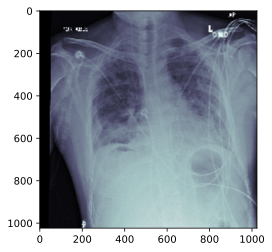

In [70]:
dataset = DatasetReader('/Users/scp-173/Datasets/RSNA_competiton/')
img = dataset.read_single_image('470595fa-5702-4009-9b56-88549ad8c560')
imshow(img, cmap='bone')

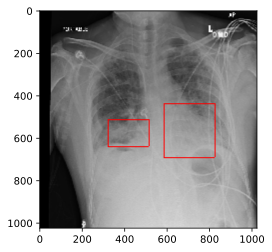

In [71]:
label_image = dataset.get_single_label_image('470595fa-5702-4009-9b56-88549ad8c560', stroke=6)
imshow(label_image, cmap='bone')

In [66]:
from skimage import io
io.imsave('test.png', label_image)

In [25]:
dataset.df_info.sample(15)

,patientId,x,y,width,height,Target,class
23176,d0d7dab6-1938-4859-beca-987458d20699,77.0,328.0,277.0,285.0,1,2
4712,40c31d96-78f1-4d21-984b-db5c143a43e4,290.0,555.0,150.0,158.0,1,2
13390,86d88303-5909-4655-81db-e4d62fdc5e33,NaN,NaN,NaN,NaN,0,1
5469,470595fa-5702-4009-9b56-88549ad8c560,583.0,437.0,238.0,253.0,1,2
3363,37e921ef-53bc-4b10-82cb-82aec4555655,NaN,NaN,NaN,NaN,0,1
11048,73cb75e6-0cef-4f7a-9c8d-cc9cc4eb0fd7,213.0,360.0,219.0,332.0,1,2
19656,b6019839-752f-4db1-bf83-f5460472deb1,739.0,465.0,120.0,114.0,1,2
2752,33e4f74e-b8f2-470b-8815-6ee3e94b8590,532.0,95.0,295.0,790.0,1,2
8182,5d509f49-de98-4cb3-a6a2-956772b89473,NaN,NaN,NaN,NaN,0,1
8122,5cde22a6-dc4b-4306-8af7-a81baa15734b,163.0,780.0,204.0,174.0,1,2
